This notebook is tested with Python 3.5 and ELFI v. 0.6.3

In [1]:
import time
import sys
import operator

import numpy as np
import matplotlib.pyplot as plt
from IPython import display

import elfi

%matplotlib inline

In [2]:
# Add the code folder to the path
sys.path.append('code')

In [3]:
import simulator as si
import elfi_operations as ops

## Simulator illustration

Run the simulator but track only the population sizes.

Balance sizes (compliant, non-compliant) =  (87.298982605842141, 78.765999343616869)


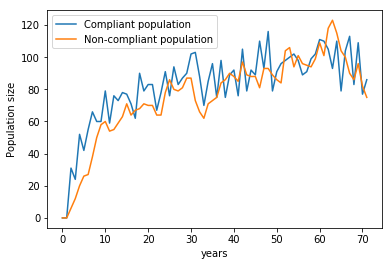

In [4]:
s = si.Simulator(200, 0.1, 6, trans_non_c=4.35, death_non_c=0.35, t_obs=np.inf, t_warmup=0,
                 track_clusters=False)

pops = [[0,0]]
deaths = [0]

for y in range(71):
    s.advance_to(y)
    pops.append([s.n_c, s.n_nc])

plt.plot(pops)
plt.ylabel('Population size')
plt.xlabel('years')
plt.legend(['Compliant population', 'Non-compliant population'])

print('Balance sizes (compliant, non-compliant) = ', s.analytical_means[:-1])

## ELFI model

In [5]:
# Observation pediod in years
t_obs = 2

# Some bounds that discard unrealistic initial values to optimize the computation
mean_obs_bounds = (0, 350)
t1_bound = 30
a1_bound = 40

# Upper bound for the largest allowed cluster size within the observation period.
# These are chosen to eliminate early outcomes that are clearly different from the observed data.
cluster_size_bound = 80
warmup_bounds = (15, 300)

y0 = ops.get_SF_data(cluster_size_bound)
d0 = 5.95

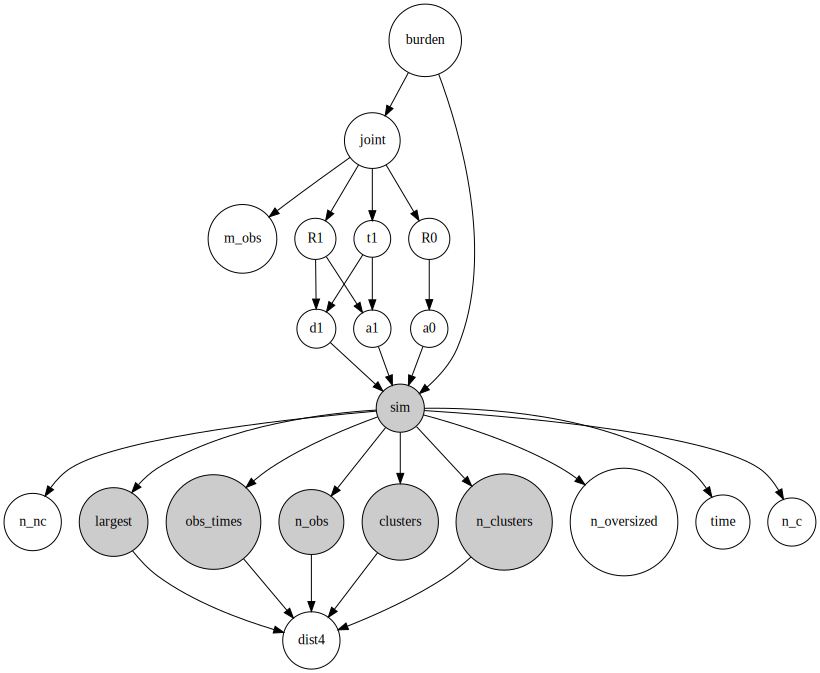

In [6]:
m = elfi.new_model()

burden = elfi.Prior('normal', 200, 30)

joint = elfi.RandomVariable(ops.JointPrior, burden, mean_obs_bounds, t1_bound, a1_bound)

R0 = elfi.Prior(ops.DummyPrior, joint, 0)
R1 = elfi.Prior(ops.DummyPrior, joint, 1)
t1 = elfi.Prior(ops.DummyPrior, joint, 2)

# Turn them to rate parameters that the simulator understands
a0 = elfi.Operation(operator.mul, R0, d0)
a1 = elfi.Operation(ops.Rt_to_a, R1, t1)
d1 = elfi.Operation(ops.Rt_to_d, R1, t1)

# Add the simulator
sim = elfi.Simulator(ops.simulator, burden, a0, d0, a1, d1, 2, cluster_size_bound, warmup_bounds, observed=y0)

# Summaries
clusters = elfi.Summary(ops.pick, sim, 'clusters')
n_obs = elfi.Summary(ops.pick, sim, 'n_obs')
n_clusters = elfi.Summary(ops.pick, sim, 'n_clusters')
largest = elfi.Summary(ops.pick, sim, 'largest')
obs_times = elfi.Summary(ops.pick, sim, 'obs_times')

# Distance
dist4 = elfi.Discrepancy(ops.distance, n_obs, n_clusters, largest, clusters, obs_times)

# Add some other interesting side products of the simulations
n_oversized = elfi.Operation(ops.pick, sim, 'n_oversized')
elfi.Operation(ops.pick, sim, 'time', name='time')
n_c = elfi.Operation(ops.pick, sim, 'n_c')
n_nc = elfi.Operation(ops.pick, sim, 'n_nc')
m_obs = elfi.Operation(operator.getitem, joint, (slice(None), 3))

elfi.draw(m)

### Test the model

In [ ]:
# Generate 3 values from each node of the model
m.generate(3)

## The inference

In [8]:
# Define methods to plot the state while the inference is running.

def create_axes():
    plt.figure(figsize=(16,16))
    ax1 = plt.subplot2grid((2, 2), (0, 0))
    ax2 = plt.subplot2grid((2, 2), (0, 1))
    ax3 = plt.subplot2grid((2, 2), (1, 0)) #, colspan=2)
    ax4 = plt.subplot2grid((2, 2), (1, 1)) #, colspan=2)
    return ax1, ax2, ax3, ax4

def draw(rej, thresholds, ax1, ax2, ax3, ax4):
    display.clear_output(True)
    
    b = rej.state['samples']
    
    ax1.clear()
    ax1.set_xlim([-1, 13])
    ax1.set_ylim([-1, t1_bound])
    ax1.set_xlabel('R1')
    ax1.set_ylabel('t1')
    ax1.scatter(b['R1'], b['t1'])
    
    ax2.clear()
    ax2.set_xlim([-1, 13])
    ax2.set_ylim([0, 0.6])
    ax2.set_xlabel('R1')
    ax2.set_ylabel('R0')
    ax2.scatter(b['R1'], b['R0'])
    
    ax3.clear()
    ax3.semilogy()
    ax3.set_ylabel('threshold')
    ax3.plot(thresholds)
    ax3.legend(['1', '100', '1000'])
    
    ax4.clear()
    ax4.set_xlim([0, 13])
    ax4.set_xlabel('R1')
    ax4.hist(b['R1'][np.isfinite(b['dist4'])], range=(-1,14), bins=20)
    
    display.display(ax2.figure)

In [9]:
# Setup a pool to store selected outputs from the ELFI model nodes (optional)
# In production, it is recommended to use the `elfi.ArrayPool` that uses persisted numpy arrays
pool = elfi.OutputPool(m.parameter_names + ['n_obs', 'n_clusters', 'largest', 'clusters', 'time', 'obs_times', 
                                           'n_oversized', 'n_c', 'n_nc', 'm_obs'], name='tbpool')


In [10]:
# Setup the parallel client
# The actual study used ipyparallel client connected to a slurm based computational cluster.
elfi.set_client('multiprocessing')

In [11]:
# In the study, the randomly selected seed and the batch_size were
# seed = 3331714042
# batch_size = 200

# Create the inference object. Using a smaller batch_size for demonstration purposes.
# In production, adjust the max_parallel_batches according to the available memory and cores
rej = elfi.Rejection(m, 'dist4', seed=None, batch_size=10, pool=pool, output_names=pool.output_names,
                     max_parallel_batches=16)

# Set the number of simulations and the sample size (we used 6M simulations in the study)
n_sim = 5000
rej.set_objective(n_samples=1000, n_sim=n_sim)

We will create a sample of 1000 points from the approximate posterior distribution with ELFI. The first 1000 points
in the animation below are directly from the prior. After that points with largest distances are started to be discarded as the threshold of the 1000 sample points shrinks. You will see in real time how the scatter plot slowly transforms from the prior towards the posterior after 1000 simulations.

Here we run only 5000 simulations for illustration. In the actual study 6M simulations were generated using a computational cluster.

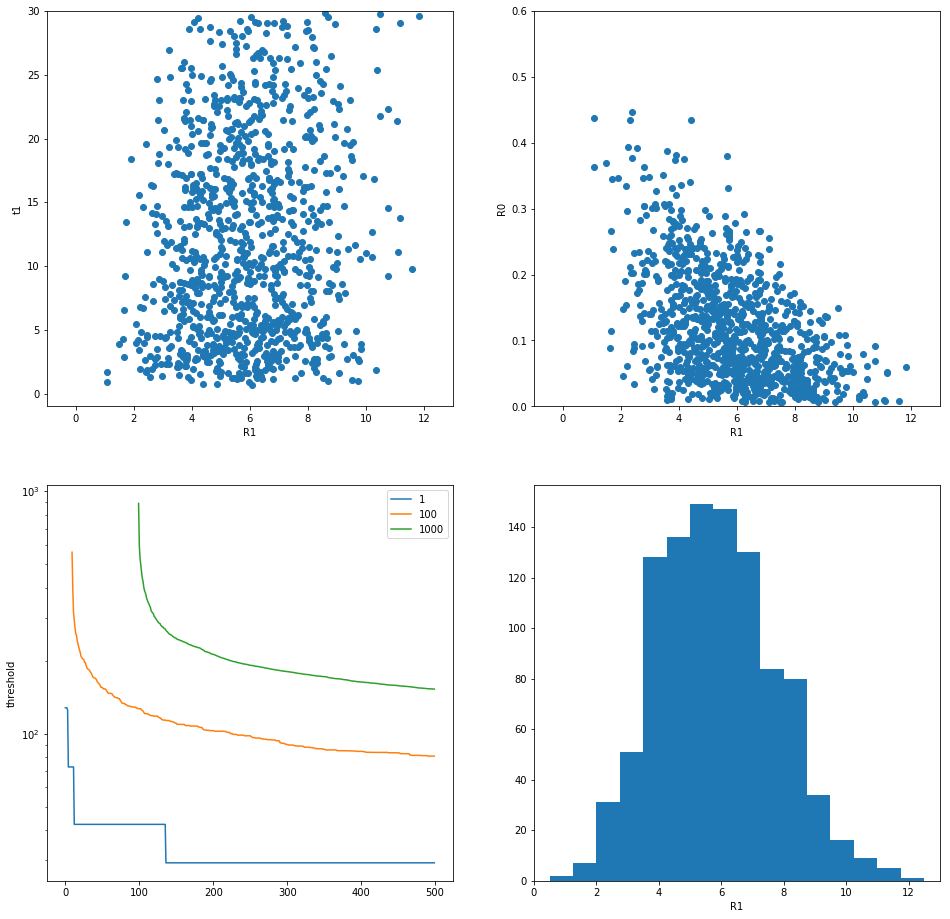

In [12]:
axes = create_axes()

thresholds = []

while not rej.finished:
    rej.iterate()
    
    thresholds.append([rej.state['samples']['dist4'][ss] for ss in [0, 99, 999]])
    draw(rej, thresholds, *axes)
    print(time.strftime("%d.%m.%Y %H:%M:%S"), ':', rej.state['n_sim'], "simulations generated.")

display.clear_output(True)

The approximation error after 5000 simulations is still significant due to the small number of simulations. However, especially the R0 and R1 approximate marginal posteriors have visibly started to progress towards the true posterior.

OrderedDict([('R0', 0.1192221276773168),
             ('R1', 5.8594211545502075),
             ('burden', 189.79935479866117),
             ('t1', 12.102706339086916)])

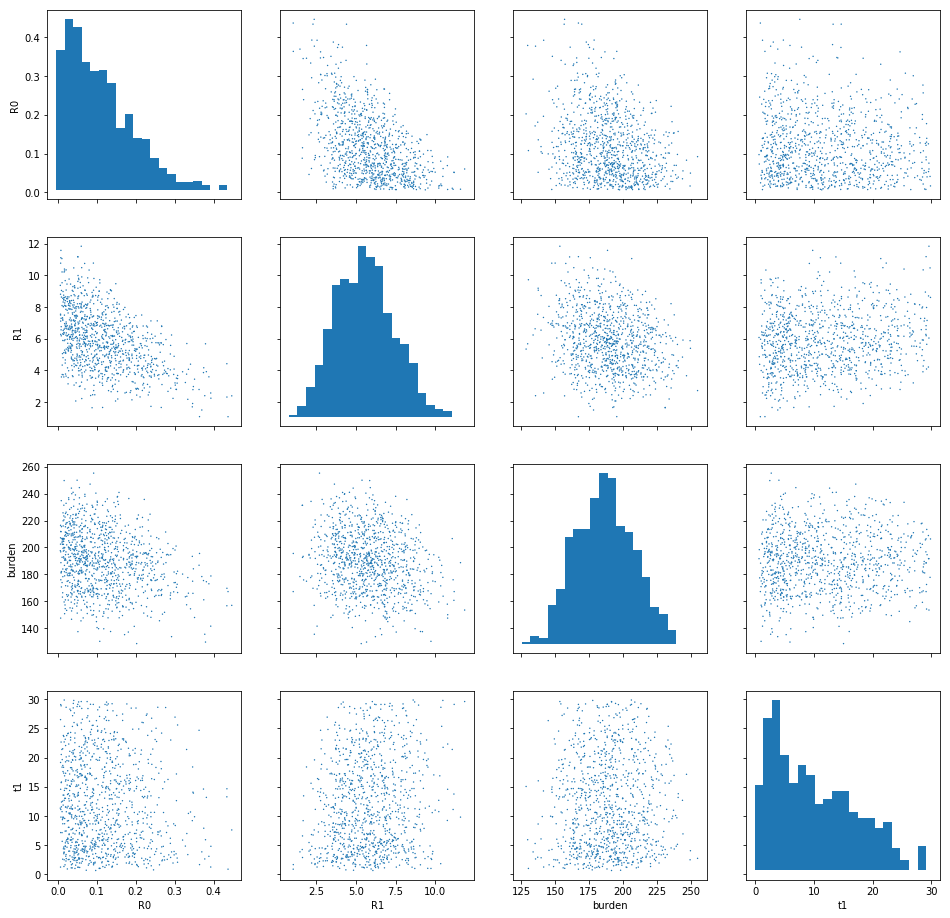

In [14]:
sample = rej.extract_result()
sample.plot_pairs();
sample.sample_means